In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"
# Load Model and tokenizers
tokenizer = AutoTokenizer.from_pretrained("yash3056/Llama-3.2-1B-imdb")
model = AutoModelForSequenceClassification.from_pretrained("yash3056/Llama-3.2-1B-imdb", num_labels=2) #n is the number of labels in the code
model.model.config._attn_implementation = "sdpa"

In [3]:
import os
import sys
module_path = os.path.join(os.getcwd(), '..')
sys.path.append(module_path)

In [4]:
from lrp_engine import LRPEngine, checkpoint_hook

In [5]:
for layer in model.model.layers:
    layer.self_attn.o_proj.register_forward_hook(checkpoint_hook)

In [6]:
model.to(device)

LlamaForSequenceClassification(
  (model): LlamaModel(
    (embed_tokens): Embedding(128256, 2048, padding_idx=128001)
    (layers): ModuleList(
      (0-15): 16 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (k_proj): Linear(in_features=2048, out_features=512, bias=False)
          (v_proj): Linear(in_features=2048, out_features=512, bias=False)
          (o_proj): Linear(in_features=2048, out_features=2048, bias=False)
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=2048, out_features=8192, bias=False)
          (up_proj): Linear(in_features=2048, out_features=8192, bias=False)
          (down_proj): Linear(in_features=8192, out_features=2048, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm((2048,), eps=1e-05)
        (post_attention_layernorm): LlamaRMSNorm((2048,), eps=1e-05)
      )
    )
    (norm): LlamaRMSNorm((20

In [7]:
import os
# Download from here: https://ai.stanford.edu/~amaas/data/sentiment/
filepath1 = "../../external/aclImdb/test/pos/"
filepath2 = "../../external/aclImdb/test/neg/"
filenames1 = os.listdir(filepath1)[:100]
filenames2 = os.listdir(filepath2)[:100]

In [8]:
# Read the examples in and prepare them for model input + LRP
pos_reviews = []
neg_reviews = []
for filename in filenames1:
    with open(filepath1 + filename, "r") as fileIn:
        line = fileIn.readline().strip()
        pos_reviews.append(line)
for filename in filenames2:
    with open(filepath2 + filename, "r") as fileIn:
        line = fileIn.readline().strip()
        neg_reviews.append(line)
print(len(pos_reviews), len(neg_reviews))
all_inputs = sorted([ tokenizer(x, return_tensors = 'pt', max_length=256, truncation=True)["input_ids"] for x in pos_reviews + neg_reviews ], key=lambda t: t.shape[-1], reverse=True)


100 100


In [9]:
outputs : torch.Tensor = model(all_inputs[0].to(device))

In [10]:
lrp_engine = LRPEngine()

In [11]:
# Run first pass
relevance_outputs = lrp_engine.run(outputs.logits.neg())

In [12]:
# Run a second pass on same output to ensure consistency
relevance_outputs1 = lrp_engine.run(outputs.logits.neg())

In [13]:
# Check results diff between 1st pass and 2nd pass on same input (should be ~0)
checkpoint_vals = relevance_outputs[0]
checkpoint_vals1 = relevance_outputs1[0]
embedding_vals = relevance_outputs[1]
embedding_vals1 = relevance_outputs1[1]
[
    ((c1 - c2)**2).sum()
    for (c1, c2) in zip(checkpoint_vals + embedding_vals, checkpoint_vals1 + embedding_vals1)
]

[tensor(5.4703e-19, device='cuda:0'),
 tensor(5.4918e-19, device='cuda:0'),
 tensor(4.1683e-19, device='cuda:0'),
 tensor(7.7807e-19, device='cuda:0'),
 tensor(1.0757e-18, device='cuda:0'),
 tensor(2.0130e-17, device='cuda:0'),
 tensor(2.6862e-18, device='cuda:0'),
 tensor(7.3842e-20, device='cuda:0'),
 tensor(5.5212e-19, device='cuda:0'),
 tensor(6.9258e-19, device='cuda:0'),
 tensor(1.6871e-21, device='cuda:0'),
 tensor(1.8033e-19, device='cuda:0'),
 tensor(3.1770e-20, device='cuda:0'),
 tensor(3.4504e-20, device='cuda:0'),
 tensor(2.4483e-19, device='cuda:0'),
 tensor(2.7126e-20, device='cuda:0'),
 tensor(1.6073e-18, device='cuda:0')]

In [14]:
from util import accumulate_variable_matrix, visualize_attention_layer_relevance

In [15]:
from tqdm import tqdm
all_reviews = neg_reviews + pos_reviews
embedding_vals = []
input_idxs = []
preds = []
agg_checkpoint_vals = None
for i in tqdm(range(200)):
    inputs = tokenizer(all_reviews[i], return_tensors = 'pt', max_length=128, truncation=True)["input_ids"]
    outputs : torch.Tensor = model(inputs.to(device))
    relevance_outputs = lrp_engine.run(outputs.logits.neg())

    checkpoint_vals = relevance_outputs[0]
    checkpoint_vals = [ c.squeeze(0) if c.dim() == 3 else c for c in checkpoint_vals ]
    embedding_vals.append(relevance_outputs[1])
    input_idxs.append(inputs)
    preds.append(outputs.logits.detach())
    
    if agg_checkpoint_vals is None:
        agg_checkpoint_vals = checkpoint_vals
    else:
        for j in range(len(agg_checkpoint_vals)):
            accumulate_variable_matrix(agg_checkpoint_vals[j], checkpoint_vals[j])
            # agg_checkpoint_vals[j] += checkpoint_vals[j]

100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:38<00:00,  5.26it/s]


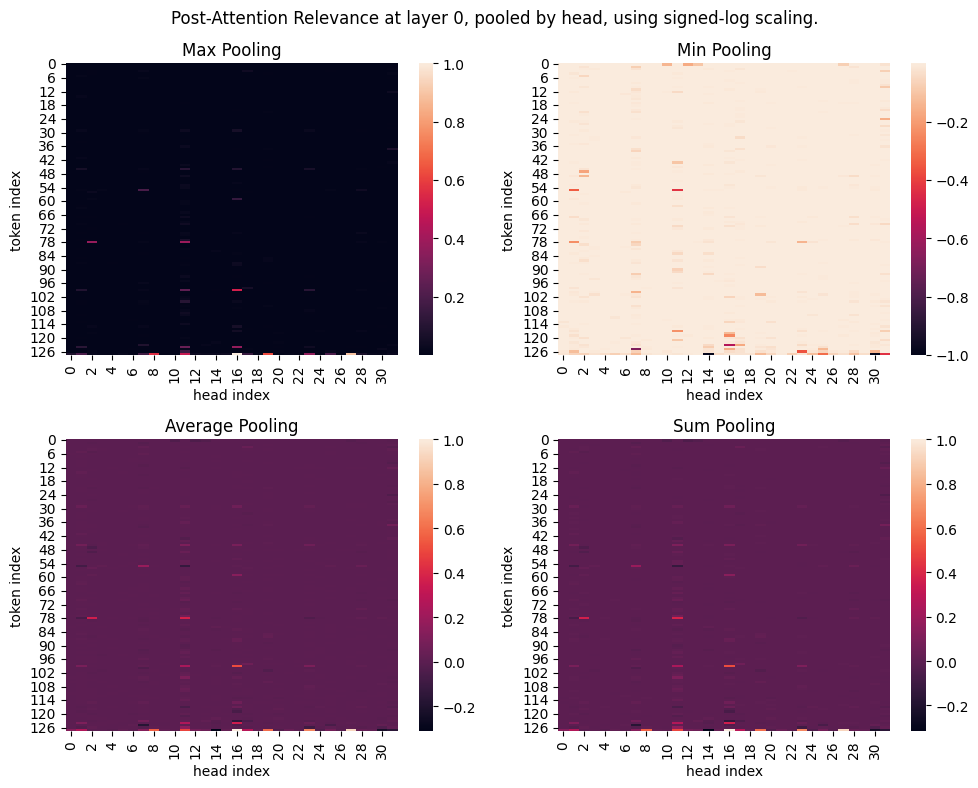

In [16]:
visualize_attention_layer_relevance(agg_checkpoint_vals, layer_ind=0)

<|begin_of_text|>. a. actionmen. the Pax Bill the lives
tensor([[-3.8367, -0.7544]], device='cuda:0')
Not even the Beatles could write songs everyone liked, and although Walter Hill is no mop-top he's second to none when it comes to thought provoking action movies. The nineties came and social platforms were changing in music and film, the emergence of the Rapper turned movie star was in full swing, the acting took a back seat to each man's overpowering regional accent and transparent acting. This was one of the many ice-t movies i saw as a kid and loved, only to watch them later and cringe. Bill Paxton and William Sadler are firemen with basic lives until a burning building tenant about to go up in flames hands over a map with gold implications. I hand it to Walter for quickly and neatly setting up the main characters and location. But i fault everyone involved for turning out Lame-o performances. Ice-t and cube must have been red hot at this time, and while I've enjoyed both their ca

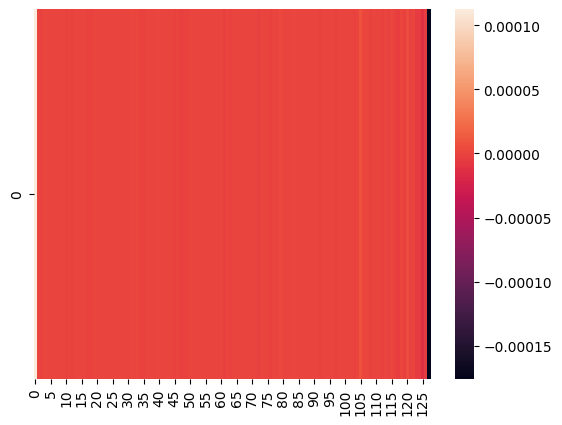

In [21]:
import seaborn as sns
example_ind = 3
sns.heatmap(embedding_vals[example_ind][0].cpu())
print(tokenizer.decode(input_idxs[example_ind][0][embedding_vals[example_ind][0].cpu().flatten().topk(12).indices]))
print(preds[example_ind])
print(all_reviews[example_ind])
